# Data Processing 

In [8]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [9]:
# All variables we concern about
columnNames1 = ["releaseNum", "1968ID", "personNumber", "gender", "marriage", "familyNumber", "sequenceNum", 
               "relationToHead", "age", 'employmentStatus', "education", "nonHeadlaborIncome"]

columnNames2 = ["releaseNum", "1968ID", "personNumber", "gender", "marriage", "familyNumber", "sequenceNum", 
               "relationToHead", "age", 'employmentStatus', "education"]

FcolumnNames1999_2001 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'employmentStatus', 
               'liquidWealth', 'race', 'industry' ,'geoCode','incomeHead', "incomeWife", 
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]

FcolumnNames2003_2007 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'employmentStatus', 
               'liquidWealth', 'race', 'industry', 'incomeHead', "incomeWife", 
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'geoCode', 'education', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]

FcolumnNames2019 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'employmentStatus', 
               'liquidWealth', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'geoCode', 'education']
# The timeline we care about
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017]

# The function used to complile all years data into one dataFrame, 
# the input "features" is a list of features.
def compile_data_with_features(features, years):
    df = pd.DataFrame()
    # Loading the data through years
    for year in years:
        df_sub = pd.read_excel("individual/" + str(year) + ".xlsx")
        if year >= 2005:
            df_sub.columns = columnNames1
            df_sub['year'] = year
            df = pd.concat([df, df_sub[['year'] + features + ["nonHeadlaborIncome"]]])
        else:
            df_sub.columns = columnNames2
            df_sub['year'] = year
            df = pd.concat([df, df_sub[['year'] + features]])
    df = df.reset_index(drop = True)
    return df

def Fcompile_data_with_features(features, years):
    df = pd.DataFrame()
    # Loading the data through years
    for year in years:
        df_sub = pd.read_excel("family/" + str(year) + ".xlsx")
        if year >= 1999 and year <= 2001:
            df_sub.columns = FcolumnNames1999_2001
        elif year >= 2003 and year <= 2007:
            df_sub.columns = FcolumnNames2003_2007
        else:
            df_sub.columns = FcolumnNames2019
        df_sub['year'] = year
        df = pd.concat([df, df_sub[['familyID','year'] + features]])
    df = df.reset_index(drop = True)
    return df

# The function is used to drop the values we do not like in the dataFrame, 
# the input "features" and "values" are both list
def drop_values(features, values, df): 
    for feature in features:
        for value in values:
            df = df[df[feature] != value]
    df = df.reset_index(drop = True)
    return df

### Individual Data

In [10]:
Idf = compile_data_with_features(["1968ID", "personNumber", "familyNumber","gender", "marriage", 
                                  "age", 'employmentStatus', "education", "relationToHead"], years)
Idf["ID"] = Idf["1968ID"]* 1000 + Idf["personNumber"]
# pick out the head in the individual
df_head = Idf[Idf["relationToHead"] == 10]
df_head = df_head.reset_index(drop = True)
# compile individuals with all 10 years data.
completeIndividualData = []
for ID, value in df_head.groupby("ID"):
    if len(value) == len(years):
        completeIndividualData.append(value)
print("Number of heads with complete data: ", len(completeIndividualData))

Number of heads with complete data:  3074


### Family Data

In [11]:
# prepare the combined dataset and set up dummy variables for qualitative data
df = Fcompile_data_with_features(['composition', 'headCount', 'ageHead', 'maritalStatus', 'employmentStatus', 
                                   'liquidWealth', 'race', 'industry' ,'geoCode','incomeHead', "incomeWife", 
                                   'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 
                                 'healthCost', 'education', 'participation', 'investmentAmount', 'annuityIRA', 
                                 'wealthWithoutHomeEquity', "wealthWithHomeEquity"], years)

In [12]:
df.shape

(83831, 25)

In [13]:
df = drop_values(["ageHead"],[999], df)
df = drop_values(["maritalStatus"],[8,9], df)
df = drop_values(["employmentStatus"],[0, 22, 98, 99], df)
df = drop_values(["liquidWealth"],[999999998,999999999], df)
df = drop_values(["race"],[0,8,9], df)
df = drop_values(["industry"],[999,0], df)
df = drop_values(["education"],[99,0], df)
df["totalExpense"] = df[['foodCost', 'houseCost', 'transCost', 
                                      'educationCost', 'childCost', 'healthCost']].sum(axis = 1)
df["laborIncome"] = df["incomeHead"] + df["incomeWife"]
df["costPerPerson"] = df["totalExpense"]/df["headCount"]



maritalStatus = ["Married", "neverMarried", "Widowed", "Divorced", "Separated"]
employmentStatus = ["Working", "temporalLeave", "unemployed", "retired", "disabled", "keepHouse", "student", "other"]
race = ["White", "Black","AmericanIndian","Asian","Latino","otherBW","otherRace"]
# Education
# < 8th grade: middle school
# >= 8 and < 12: high scho0l
# >=12 and < 15: college
# >= 15 post graduate
education = ["middleSchool", "highSchool", "college", "postGraduate"]
# Industry
# < 400 manufacturing
# >= 400 and < 500 publicUtility
# >= 500 and < 680 retail 
# >= 680 and < 720 finance
# >= 720 and < 900 service
# >= 900 otherIndustry
industry = ["manufacturing", "publicUtility", "retail", "finance", "service", "otherIndustry"]
data = []
for i in range(len(df)):
    dataCollect = []
    # marital status
    dataCollect.append(maritalStatus[int(df.iloc[i]["maritalStatus"]-1)])
    # employment
    dataCollect.append(employmentStatus[int(df.iloc[i]["employmentStatus"]-1)])
    # race
    dataCollect.append(race[int(df.iloc[i]["race"] - 1)])
    # Education variable 
    if df.iloc[i]["education"] < 8:
        dataCollect.append(education[0])
    elif df.iloc[i]["education"] >= 8 and df.iloc[i]["education"] < 12:
        dataCollect.append(education[1])
    elif df.iloc[i]["education"] >= 12 and df.iloc[i]["education"] < 15:
        dataCollect.append(education[2])
    else:
        dataCollect.append(education[3])
    # industry variable 
    if df.iloc[i]["industry"] < 400:
        dataCollect.append(industry[0])
    elif df.iloc[i]["industry"] >= 400 and df.iloc[i]["industry"] < 500:
        dataCollect.append(industry[1])
    elif df.iloc[i]["industry"] >= 500 and df.iloc[i]["industry"] < 680:
        dataCollect.append(industry[2])
    elif df.iloc[i]["industry"] >= 680 and df.iloc[i]["industry"] < 720:
        dataCollect.append(industry[3])
    elif df.iloc[i]["industry"] >= 720 and df.iloc[i]["industry"] < 900:
        dataCollect.append(industry[4])
    else:
        dataCollect.append(industry[5])
    data.append(dataCollect)
# Categorical dataFrame
df_cat = pd.DataFrame(data, columns = ["maritalStatus", "employmentStatus", "race", "education", "industry"])

In [14]:
Fdf = pd.concat([df[["familyID", "year",'composition', 'headCount', 'ageHead', 'liquidWealth', 'laborIncome', 
                     "costPerPerson","totalExpense", 'participation', 'investmentAmount', 'annuityIRA', 
                                 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]], 
                          df_cat[["maritalStatus", "employmentStatus", "education","race", "industry"]]], axis=1)
# Adjust for inflation. 
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017]
values_at2020 = np.array([1.55, 1.46, 1.40, 1.32, 1.24, 1.20, 1.15, 1.11, 1.09, 1.05])
values_at2005 = values_at2020/1.32
quantVariables = ['annuityIRA', 'investmentAmount', 'liquidWealth', 'laborIncome', 'costPerPerson','costPerPerson',
                 'totalExpense', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity']
for i in range(len(Fdf)):
    for variable in quantVariables:
        Fdf.at[i, variable] = round(Fdf.at[i, variable] * values_at2005[years.index(Fdf.at[i,"year"])], 2)

In [15]:
Fdf_20_80 = Fdf[(Fdf["ageHead"] >= 20) & (Fdf["ageHead"] <= 80)]

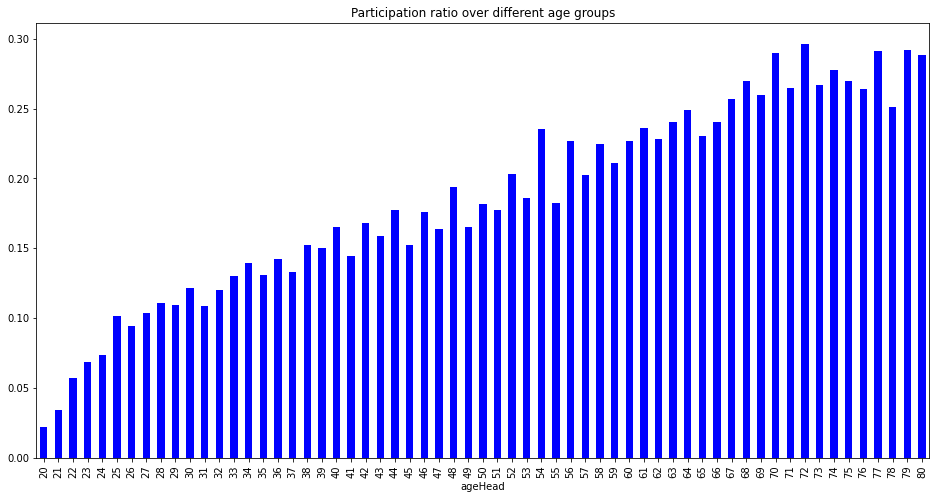

In [16]:
plt.title("Participation ratio over different age groups")
Fdf_20_80.groupby("ageHead").participation.mean().plot.bar(color = "blue")
savefig('ageParticipation.jpg')

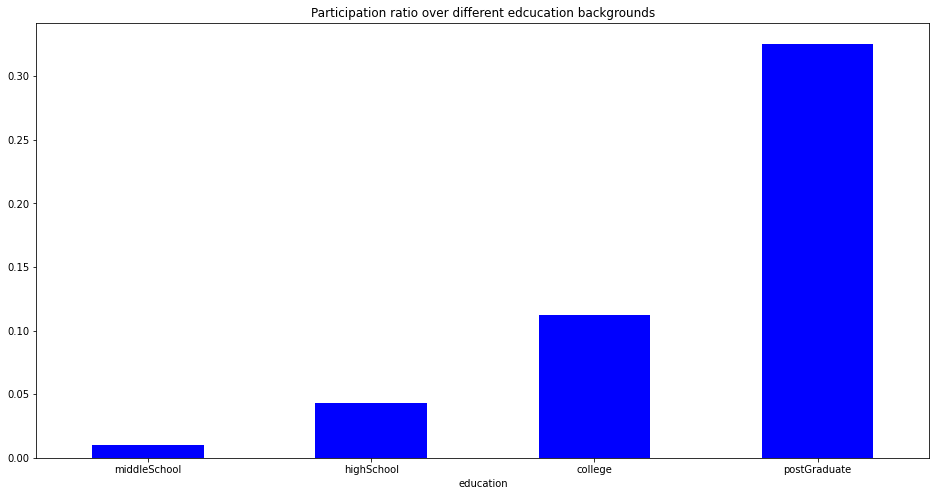

In [28]:
plt.title("Participation ratio over different edcucation backgrounds")
Fdf_20_80.groupby("education").participation.mean().reindex(["middleSchool", "highSchool", "college", "postGraduate"]).plot.bar(color = "blue",rot=0)
savefig('educationParticipation.jpg')

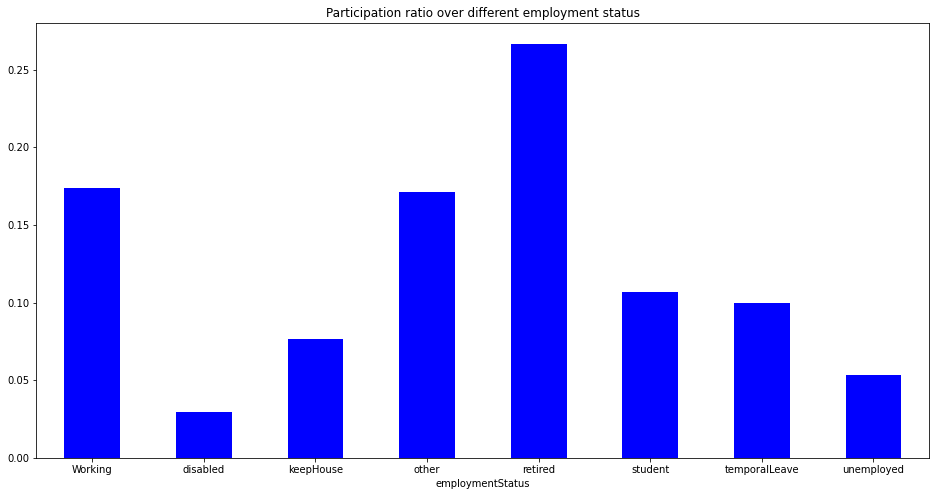

In [18]:
plt.title("Participation ratio over different employment status")
Fdf_20_80.groupby("employmentStatus").participation.mean().plot.bar(color = "blue",rot=0)
savefig('employmentParticipation.jpg')

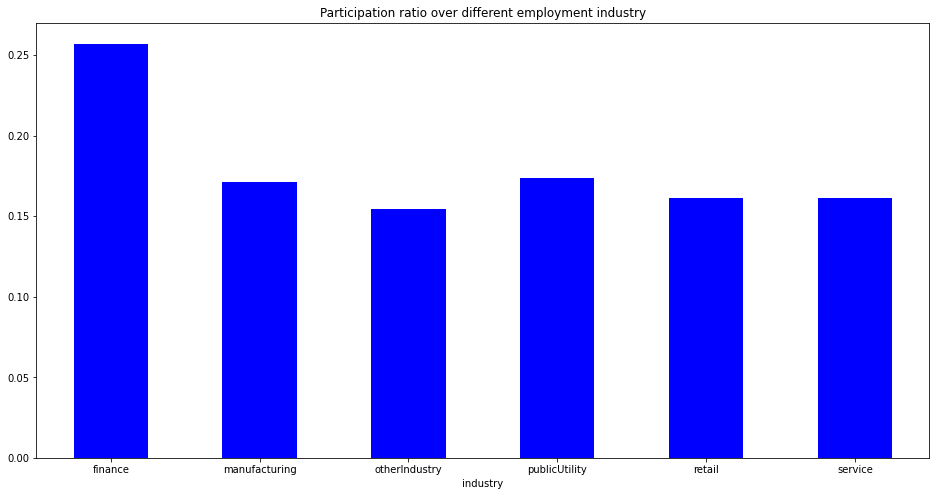

In [19]:
plt.title("Participation ratio over different employment industry")
Fdf_20_80.groupby("industry").participation.mean().plot.bar(color = "blue",rot=0)
savefig('industryParticipation.jpg')

In [20]:
Fdf_p = Fdf_20_80[Fdf_20_80.participation == 1]

In [21]:
Fdf_np = Fdf_20_80[Fdf_20_80.participation == 0]

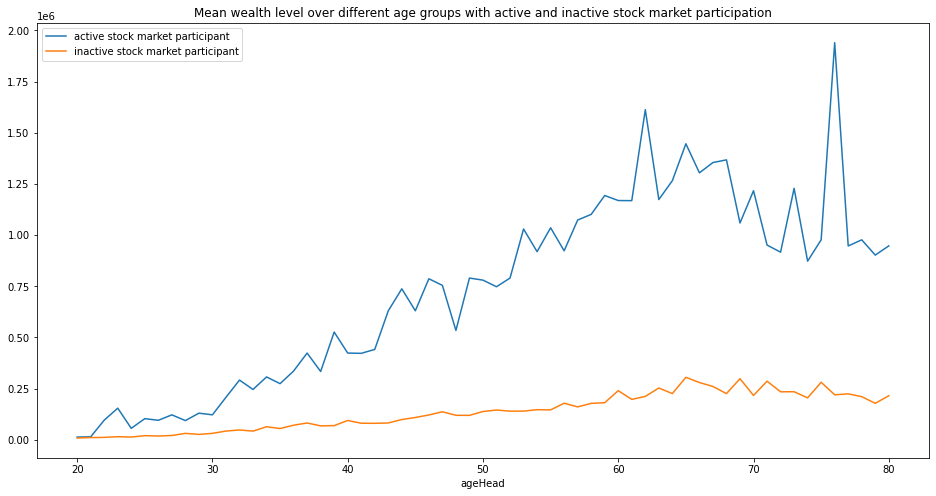

In [22]:
plt.title("Mean wealth level over different age groups with active and inactive stock market participation")
Fdf_p.groupby("ageHead").wealthWithHomeEquity.mean().plot(label = "active stock market participant")
Fdf_np.groupby("ageHead").wealthWithHomeEquity.mean().plot(label = "inactive stock market participant")
plt.legend()
savefig('wealthAccumulation.jpg')

### Link Family Data with Individual Head Data

In [ ]:
completeFamilyData = []
for individual in completeIndividualData:
    idf = pd.DataFrame()
    for i in range(len(individual)): 
        idf = pd.concat([idf, Fdf[(Fdf.year == individual.iloc[i].year)&
                                (Fdf.familyID == individual.iloc[i].familyNumber)]])
    completeFamilyData.append(idf.set_index("year", drop = True))

In [ ]:
FamilyData = [f for f in completeFamilyData if len(f) == len(years)]
len(FamilyData)

In [ ]:
# skilled definition with college and postGraduate
skilled_index = []
for i in range(1973):
    if "postGraduate" in FamilyData[i].education.values or "college" in FamilyData[i].education.values:
        skilled_index.append(i)
len(skilled_index)

In [ ]:
# skilled definition with postGraduate
skilled_index = []
for i in range(1973):
    if "postGraduate" in FamilyData[i].education.values:
        skilled_index.append(i)
len(skilled_index)

In [ ]:
# working in the finance industry
finance_index = []
for i in range(1973):
    if "finance" in FamilyData[i].industry.values:
        finance_index.append(i)
len(finance_index)

In [ ]:
a = FamilyData[randint(0, 1973)]
a

# Individual plot

In [ ]:
def inFeaturePlot(FamilyData, feature, n):
    plt.figure()
    for i in range(n[0],n[1]):
        FamilyData[i][feature].plot(marker='o')
    plt.show()

def plotFeatureVsAge(FamilyData, feature, n):
    plt.figure()
    for i in range(n[0],n[1]):
        plt.plot(FamilyData[i].ageHead, FamilyData[i][feature], marker = 'o')
    plt.show()

In [ ]:
inFeaturePlot(FamilyData,"laborIncome" , [1,100])

# Average variable plot

In [ ]:
def plotFeature(FamilyData, feature):
    df = FamilyData[0][feature] * 0
    for i in range(len(FamilyData)):
        df = df + FamilyData[i][feature]
    df = df/len(FamilyData)
    df.plot(marker='o')
    print(df)

In [ ]:
# laborIncome
plotFeature(FamilyData, "laborIncome")

In [ ]:
# laborIncome
plotFeature(FamilyData, "investmentAmount")

In [ ]:
# Expenditure
plotFeature(FamilyData, "totalExpense")

In [ ]:
# wealthWithoutHomeEquity
plotFeature(FamilyData, "wealthWithoutHomeEquity")

In [ ]:
# wealthWithHomeEquity
plotFeature(FamilyData, "wealthWithHomeEquity")

In [ ]:
plotFeature(FamilyData, "annuityIRA")

## Compare The Distribution Over Age

In [ ]:
df = Fdf[(Fdf["ageHead"]>=20) & (Fdf["ageHead"]<=80)]
df[['liquidWealth', 'laborIncome', 'costPerPerson', 'totalExpense','investmentAmount', 'annuityIRA',
       'wealthWithoutHomeEquity', 'wealthWithHomeEquity']] = df[['liquidWealth', 'laborIncome', 'costPerPerson', 'totalExpense','investmentAmount', 'annuityIRA',
       'wealthWithoutHomeEquity', 'wealthWithHomeEquity']]/1000
df.shape

In [ ]:
df.columns

In [ ]:
ww = df.groupby("ageHead")["liquidWealth"].mean()
nn = df.groupby("ageHead")["annuityIRA"].mean()
cc = df.groupby("ageHead")["totalExpense"].mean()
kk = df.groupby("ageHead")["investmentAmount"].mean()
ytyt = df.groupby("ageHead")["laborIncome"].mean()

In [ ]:
plt.figure(figsize = [14,8])
plt.plot(ww, label = "liquidWealth")
plt.plot(cc, label = "Consumption")
plt.plot(kk, label = "Stock")
plt.plot(nn, label = "IRA")
plt.legend()

In [ ]:
plt.plot(nn, label = "IRA")

In [ ]:
np.save('nn',nn)

In [ ]:
plt.style.use('ggplot')

In [ ]:
Fdf.head(10)

In [ ]:
Fdf.groupby("ageHead").totalExpense.mean()[2:62].plot()
Fdf.groupby("ageHead").wealthWithoutHomeEquity.mean()[2:62].plot()

In [ ]:
Fdf.groupby("ageHead").wealthWithHomeEquity.quantile(0.25)[2:62].plot()
Fdf.groupby("ageHead").wealthWithHomeEquity.quantile(0.5)[2:62].plot()
Fdf.groupby("ageHead").wealthWithHomeEquity.quantile(0.75)[2:62].plot()

In [ ]:
# Fdf.groupby("ageHead").annuityIRA.quantile(0.25)[2:62].plot()
# Fdf.groupby("ageHead").annuityIRA.quantile(0.5)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.50)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.55)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.60)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.65)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.70)[2:62].plot()
Fdf.groupby("ageHead").annuityIRA.quantile(0.75)[2:62].plot()